[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1peT_mx4XCYQe1o2O6NmK0ITDJj2Ali8o?usp=sharing)

## Preable - Install Deps

There are only a few dependencies for this tutorial.

In [13]:
!pip3 install pyautogen openai fireworks-ai matplotlib opencv-python yfinance


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


## Introduction -  Stock Chart Generator

In this example we will use AutoGen framework to construct an agent that is capable of generating an stock price charts.

For this demo, we are going to utilize [function calling](https://readme.fireworks.ai/docs/function-calling) feature launched by Fireworks. We initialize two agents - `UserProxyAgent` and `AssistantAgent`. The `AssistantAgent` is given the ability to issue a call for the provided functions but not execute them while `UserProxyAgent` is given the ability to execute the function calls issues by the `AssistantAgent`. In order to achieve this behaviour we use decorators provided by AutoGen library called `register_for_llm` and `register_for_execution`. Using these decorators allows us to easily define python functions and turn them into [JSON Spec](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat) needed by function calling API.

Finally, we setup system prompt for both the agents. We ask the `AssistantAgent` to be a helpful agent & focus on generating the correct function calls and we leave `UserProxyAgent` as is. For more advanced use cases we can ask `UserProxyAgent` to be a plan generator.

In [14]:
import hashlib
import json
import os
import re
import uuid
from pathlib import Path
from typing import Any, Dict, List, Optional

import autogen
import pandas as pd
import requests  # to perform HTTP requests
import yfinance as yf
from matplotlib import pyplot as plt
from openai import OpenAI
from typing_extensions import Annotated

## Setup

In order to use the Fireworks AI function calling model, you must first obtain Fireworks API Keys. If you don't already have one, you can one by following the instructions [here](https://readme.fireworks.ai/docs/quickstart). Replace FW_API_KEY with your obtained key.

In [15]:
os.environ["AUTOGEN_USE_DOCKER"] = "0"

In [16]:
FW_API_KEY = "FW_API_KEY"

config_list = [
    {
        'api_key': FW_API_KEY,
        'base_url': 'https://api.fireworks.ai/inference/v1',
        'model': 'accounts/fireworks/models/firefunction-v1'
    }
]

## Configure Tools

For this notebook, we are going to use 2 sets of tools
1. **Get Prices** - We will use the [yfinance](https://pypi.org/project/yfinance/) package to obtain stock prices for a given ticker. The stock prices can be obtained over a custom time range and would be saved as a time series in a csv file.
2. **Show Chart** - This tool, given a valid file path, will draw a time series.


Using the AutoGen framework we demonstrate the co-operative nature of agents working with each other to accomplish a complex task. This tutorial can be extended to perform more complicated tasks such as generating stock price charts etc.

user_proxy (to chatbot):

Get stock prices of NVDA stock price YTD. Then plot them on a chart.

--------------------------------------------------------------------------------
[autogen.oai.client: 11-08 16:27:08] {409} WARNING - Model accounts/fireworks/models/firefunction-v1 is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
chatbot (to user_proxy):

***** Suggested tool call (call_Msjlx4BDdoZrOlpd4aE5wVzm): get_prices *****
Arguments: 
{"ticker": "NVDA", "period": "ytd"}
***************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_prices...
user_proxy (to chatbot):

user_proxy (to chatbot):

***** Response from calling tool (call_Msjlx4BDdoZrOlpd4aE5wVzm) *****
/tmp/eef5738c-81d9-4cca-baef-c6a13f32186a.csv
************************************************

ChatResult(chat_id=None, chat_history=[{'content': 'Get stock prices of NVDA stock price YTD. Then plot them on a chart.', 'role': 'assistant', 'name': 'user_proxy'}, {'tool_calls': [{'id': 'call_Msjlx4BDdoZrOlpd4aE5wVzm', 'function': {'arguments': '{"ticker": "NVDA", "period": "ytd"}', 'name': 'get_prices'}, 'type': 'function', 'index': 0}], 'content': None, 'role': 'assistant'}, {'content': '/tmp/eef5738c-81d9-4cca-baef-c6a13f32186a.csv', 'tool_responses': [{'tool_call_id': 'call_Msjlx4BDdoZrOlpd4aE5wVzm', 'role': 'tool', 'content': '/tmp/eef5738c-81d9-4cca-baef-c6a13f32186a.csv'}], 'role': 'tool', 'name': 'user_proxy'}, {'content': 'The stock prices of NVDA stock for the year to date (YTD) have been obtained and saved to a file at /tmp/eef5738c-81d9-4cca-baef-c6a13f32186a.csv. \n\nNow, I will plot the time series chart for the stock prices. ', 'tool_calls': [{'id': 'call_M9CvkyXQKioKJWz0icwPA5WA', 'function': {'arguments': '{"title": "NVDA Stock Prices YTD", "file_name": "/tmp/nvda_

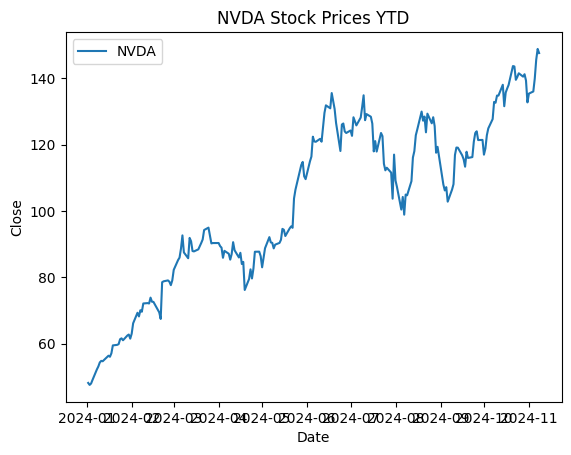

In [17]:
llm_config = {
    "config_list": config_list,
    "timeout": 120,
    "temperature": 0
}

chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message=" If the user request HAS been addressed, respond with a summary of the result. The summary MUST end with the word TERMINATE. You are a helpful AI assistant with access to functions. Use them if required.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and (
        x.get("content", "").rstrip().endswith("TERMINATE") 
        or x.get("content", "").rstrip().endswith("TERMINATE.")
    ),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False  # Add this line
    },
)


@user_proxy.register_for_execution()
@chatbot.register_for_llm(
    name="get_prices",
    description="Helper function to obtain stock price history of a company over specified period. The price information is written to a file and the path of the file is returned. The file is csv and contains following columns - Date,Open,High,Low,Close,Volume,Dividends,Stock Splits",
)
def get_prices(
    ticker: Annotated[str, "Stock ticker for a company"],
    period: Annotated[
        str,
        "data period to download (Either Use period parameter or use start and end) Valid periods are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max",
    ],
) -> Annotated[
    str, "File which contains the price of the a ticker, each price in a new line"
]:
    # Generate a random UUID as the file name
    file_name: str = "/tmp/" + str(uuid.uuid4()) + ".csv"
    file_path = Path(file_name)

    tk = yf.Ticker(ticker=ticker)
    prices = tk.history(period=period)

    with open(file_path, "w") as f:
        prices.to_csv(f)
    return file_name

@user_proxy.register_for_execution()
@chatbot.register_for_llm(
    name="draw_time_series",
    description="Plot time series chart given stock prices of multiple stock tickers in a csv file.",
)
def plot_time_series(
    title: Annotated[str, "Title of the plot that is generated"],
    file_name: Annotated[str, "File to which to save the chart"],
    csv_files: Annotated[
        Dict[str, str],
        "Dictionary from stock ticker to CSV file that contain stock prices. The csv files should have schema - Date,Open,High,Low,Close,Volume,Dividends,Stock Splits",
    ],
    date_col: Annotated[str, "Column name in csv that contains the date"] = "Date",
    price_col: Annotated[str, "Column name that contains the price"] = "Close",
) -> str:
    file_name = "/tmp/" + file_name
    for label, csv_file in csv_files.items():
        # Load the data into pandas dataframes
        price_data = pd.read_csv(csv_file, index_col=date_col, parse_dates=True)

        # Plot NVDA stock price data
        plt.plot(price_data.index, price_data["Close"], label=label)

    plt.xlabel(date_col)
    plt.ylabel(price_col)
    plt.title(title)
    plt.legend()

    # Save the plot to a file
    plt.savefig(file_name)

    print(f"Plot saved to {file_name}")

    return file_name


user_proxy.initiate_chat(
    chatbot,
    message="Get stock prices of NVDA stock price YTD. Then plot them on a chart.",
    clear_history=True
)